In [ ]:
################################################################################
######################   UsedCarPrices_CarGurus  ###############################
######################   Regression - Nonlinear  ###############################
######################   Random Forest HPO GPU   ###############################
################################################################################

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/RAPIDS/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/RAPIDS


In [ ]:
# Clone RAPIDS-Colab install files and see if GPU is compatible
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
# Update the Colab environment and restart the kernel
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [788 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/restrict

In [3]:
# Install CondaColab and restart the kernel
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:26
🔁 Restarting kernel...


In [3]:
# See if environment is ready to install RAPIDS
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [4]:
# Install RAPIDS using the 'stable' release
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Found existing installation: cffi 1.14.5
Uninstalling cffi-1.14.5:
  Successfully uninstalled cffi-1.14.5
Found existing installation: cryptography 3.4.5
Uninstalling cryptography-3.4.5:
  Successfully uninstalled cryptography-3.4.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Installing RAPIDS Stable 21.12
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec c

In [5]:
# Install/import dependencies
!pip install optuna
!pip install dask_optuna
import os
import random
import time
from contextlib import contextmanager
import dask
import dask_optuna
import dask_cudf
from dask_cuda import LocalCUDACluster
from dask.distributed import Client, wait, performance_report
import joblib
from joblib import parallel_backend
import numpy as np
import cupy as cp
import cudf
import cuml
from cuml.model_selection import train_test_split
from cuml.ensemble import RandomForestRegressor
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) 
import pickle
import pandas as pd
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

my_dpi=96

print('\n')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.1 MB/s 
     |████████████████████████████████| 209 kB 74.7 MB/s 
     |████████████████████████████████| 1.6 MB 63.3 MB/s 
     |████████████████████████████████| 81 kB 9.6 MB/s 
     |████████████████████████████████| 150 kB 57.8 MB/s 
     |████████████████████████████████| 78 kB 6.4 MB/s 
     |████████████████████████████████| 49 kB 6.2 MB/s 
     |████████████████████████████████| 112 kB 76.4 MB/s 
     |████████████████████████████████| 146 kB 63.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=2536c6b196004c404304ad7ab7986b41264aa3facdef333ab299f8efb3653c57
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/sim

In [6]:
# Define function to time code blocks
@contextmanager
def timed(name):
    t0 = time.time()
    yield
    t1 = time.time()
    print('..%-24s:  %8.4f' % (name, t1 - t0))

In [7]:
# Set up local CUDA cluster for Dask
cluster = LocalCUDACluster(threads_per_worker=1, ip='', dashboard_address='8081') 
c = Client(cluster)

# Query the client for all connected workers
workers = c.has_what().keys()
n_workers = len(workers)
c

/usr/local/lib/python3.7/site-packages/distributed/client.py:1131: VersionMismatchWarning:

Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| tornado | 5.1.1  | 5.1.1     | 6.1     |
+---------+--------+-----------+---------+



Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://172.28.0.2:8081/status,
Dashboard: http://172.28.0.2:8081/status,Workers: 1
Total threads: 1,Total memory: 25.46 GiB
Status: running,Using processes: True
Comm: tcp://172.28.0.2:42363,Workers: 1
Dashboard: http://172.28.0.2:8081/status,Total threads: 1
Started: Just now,Total memory: 25.46 GiB
Comm: tcp://172.28.0.2:39473,Total threads: 1
Dashboard: http://172.28.0.2:33761/status,Memory: 25.46 GiB
Nanny: tcp://172.28.0.2:45447,


In [8]:
# Set seed 
seed_value = 42
os.environ['RF_GPU'] = str(seed_value)
cp.random.seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [9]:
%cd /content/drive/MyDrive/UsedCarsCarGurus/Data/

/content/drive/MyDrive/UsedCarsCarGurus/Data


In [10]:
# Read data
df = cudf.read_csv('usedCars_final.csv')
print('Number of rows and columns:', df.shape)

Number of rows and columns: (327912, 28)


In [11]:
# Find categorical variables
cat_cols = list(df.select_dtypes('object').columns)

# Set up features and target
X, y = df.drop(['price'], axis=1), df['price'].astype('float32')

# Define a name for the trials
study_name = 'dask_optuna_rf_100paramsHi_rmse_tpe'

In [3]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/RF/Optuna/Model_PKL

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/RF/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, bootstrap=True, 
                   n_estimators=100, max_depth=16, 
                   max_leaves=100, min_samples_leaf=30, 
                   min_samples_split=10, n_bins=128): 
    '''
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: RMSE of the fitted model
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        random_state=seed_value)

    X_train = cudf.get_dummies(X_train, columns=cat_cols) 
    X_train = X_train.astype('float32')
    X_test = cudf.get_dummies(X_test, columns=cat_cols)
    X_test = X_test.astype('float32')

    model = RandomForestRegressor(random_state=seed_value, n_streams=1, 
                                  bootstrap=bootstrap, 
                                  n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_leaves=max_leaves, 
                                  min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split, 
                                  n_bins=n_bins)
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = mean_squared_error(y_test.to_numpy(), y_pred.to_numpy(), 
                               squared=False)     
    run_time = timer() - start

    print('- Trial RMSE:', score)
    
    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X, y))

- Trial RMSE: 4200.8613
Score with default parameters :  4200.8613


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):
    
    joblib.dump(study, 'RF_Optuna_100_GPU_paramsHi.pkl')
    
    # Search parameters 
    n_estimators = trial.suggest_int('n_estimators', 300, 1000) 
    max_depth = trial.suggest_int('max_depth', 30, 70) 
    max_leaves = trial.suggest_int('max_leaves', 300, 700) 
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 70, 150)
    min_samples_split = trial.suggest_int('min_samples_split', 20, 70) 
    n_bins = trial.suggest_int('n_bins', 128, 512)
    
    score = train_and_eval(X_param,
                           y_param,
                           bootstrap=True, 
                           n_estimators=n_estimators,
                           max_depth=max_depth,
                           max_leaves=max_leaves, 
                           min_samples_leaf=min_samples_leaf,
                           min_samples_split=min_samples_split, 
                           n_bins=n_bins)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('RF_Optuna_100_GPU_paramsHi.pkl'): 
      study = joblib.load('RF_Optuna_100_GPU_paramsHi.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='minimize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X, y), 
                       n_trials=100,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest RMSE', study.best_value)

Start Time           2022-06-02 04:09:23.146413
- Trial RMSE: 3191.7466
- Trial RMSE: 3453.6106
- Trial RMSE: 3309.4521
- Trial RMSE: 3476.4846
- Trial RMSE: 3197.8281
- Trial RMSE: 3254.0564
- Trial RMSE: 3236.2622
- Trial RMSE: 3288.815
- Trial RMSE: 3247.244
- Trial RMSE: 3261.553
- Trial RMSE: 3176.7737
- Trial RMSE: 3176.1575
- Trial RMSE: 3174.226
- Trial RMSE: 3175.5083
- Trial RMSE: 3399.9387
- Trial RMSE: 3400.7993
- Trial RMSE: 3122.6123
- Trial RMSE: 3220.2905
- Trial RMSE: 3114.3396
- Trial RMSE: 3241.2947
- Trial RMSE: 3547.9458
- Trial RMSE: 3128.5767
- Trial RMSE: 3196.1719
- Trial RMSE: 3128.602
- Trial RMSE: 3141.7468
- Trial RMSE: 3295.171
- Trial RMSE: 3184.6936
- Trial RMSE: 3171.674
- Trial RMSE: 3215.9148
- Trial RMSE: 3208.2874
- Trial RMSE: 3145.0935
- Trial RMSE: 3156.6511
- Trial RMSE: 3142.5027
- Trial RMSE: 3100.9185
- Trial RMSE: 3097.4792
- Trial RMSE: 3216.5156
- Trial RMSE: 3149.3225
- Trial RMSE: 3139.9927
- Trial RMSE: 3220.0933
- Trial RMSE: 3311.076


In [4]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/RF/Optuna/trialOptions/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/RF/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'rmse'},inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_max_leaves':'max_leaves'}, inplace=True)
trials_df.rename(columns={'params_min_samples_leaf':'min_samples_leaf'}, inplace=True)
trials_df.rename(columns={'params_min_samples_split':'min_samples_split'}, inplace=True)
trials_df.rename(columns={'params_n_bins':'n_bins'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)

trials_df = trials_df.sort_values('rmse', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('RF_Optuna_100_GPU_paramsHi.csv', index=False)

    iteration         rmse             datetime_start  \
53         53  3094.864502 2022-06-02 05:32:22.356034   
71         71  3094.869141 2022-06-02 06:08:08.331029   
34         34  3097.479248 2022-06-02 05:02:26.921354   
73         73  3098.345947 2022-06-02 06:12:08.612744   
91         91  3098.846924 2022-06-02 06:48:02.724793   
..        ...          ...                        ...   
51         51  3431.890869 2022-06-02 05:29:05.412571   
1           1  3453.610596 2022-06-02 04:10:10.389480   
3           3  3476.484619 2022-06-02 04:11:36.936442   
59         59  3504.763916 2022-06-02 05:45:29.545893   
20         20  3547.945801 2022-06-02 04:41:07.111518   

            datetime_complete               duration  max_depth  max_leaves  \
53 2022-06-02 05:34:45.985218 0 days 00:02:23.629184         70         698   
71 2022-06-02 06:10:10.716596 0 days 00:02:02.385567         63         700   
34 2022-06-02 05:04:16.104513 0 days 00:01:49.183159         47         697   

In [5]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/RF/Optuna/Model_Explanations/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/RF/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_RF_Optuna_100_GPU_paramsHi.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_RF_Optuna_100_GPU_paramsHi.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_RF_Optuna_100_GPU_paramsHi.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['max_leaves', 
                                                       'min_samples_leaf',
                                                       'max_depth', 
                                                       'min_samples_split'])
py.plot(fig, filename='contour_RF_Optuna_100_GPU_paramsHi.html')
fig.show()

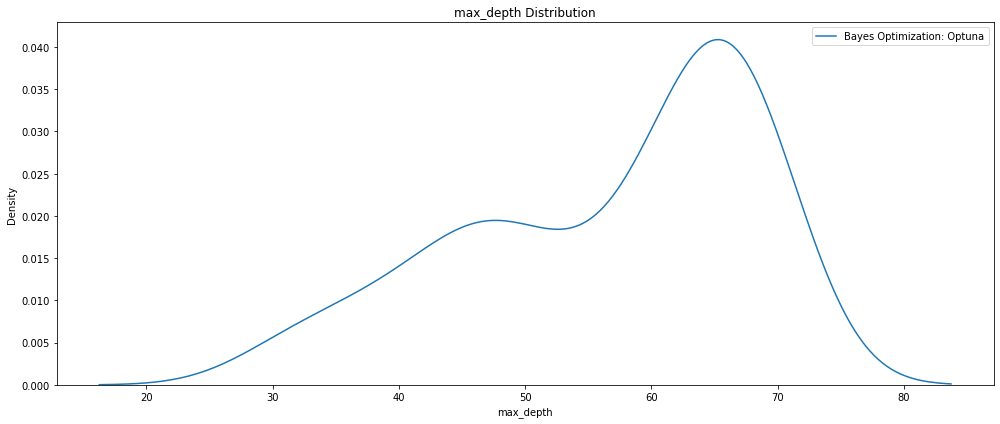

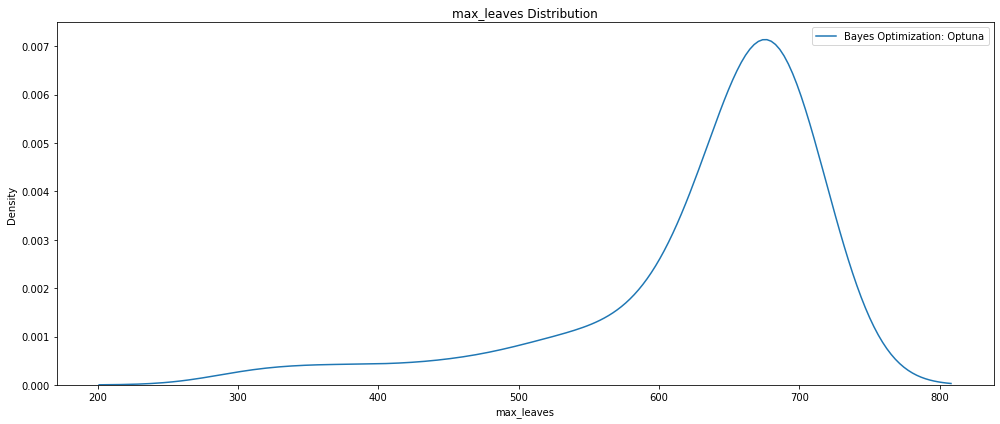

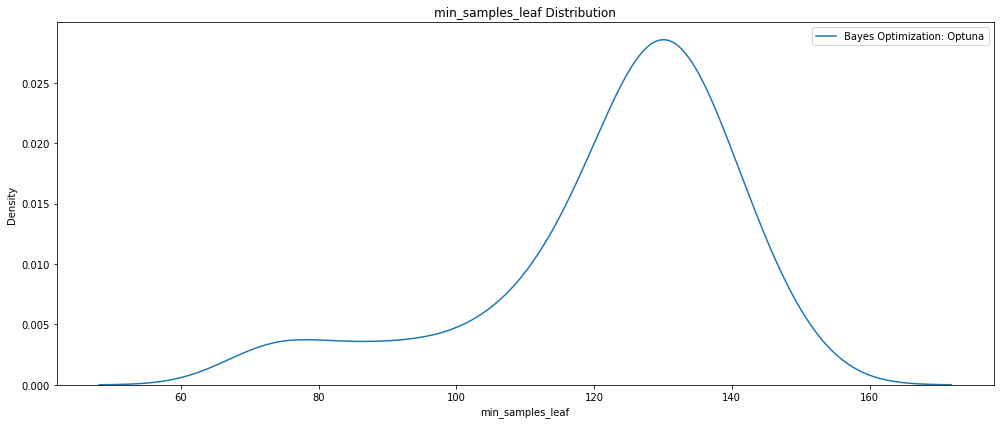

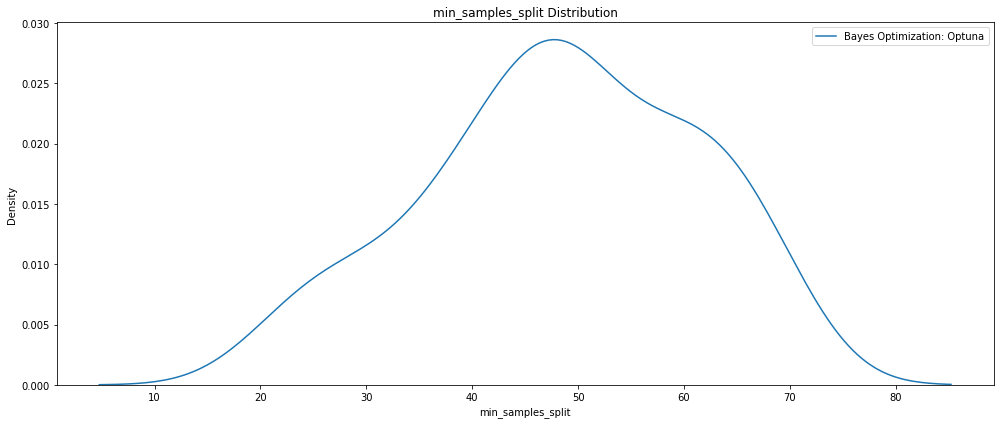

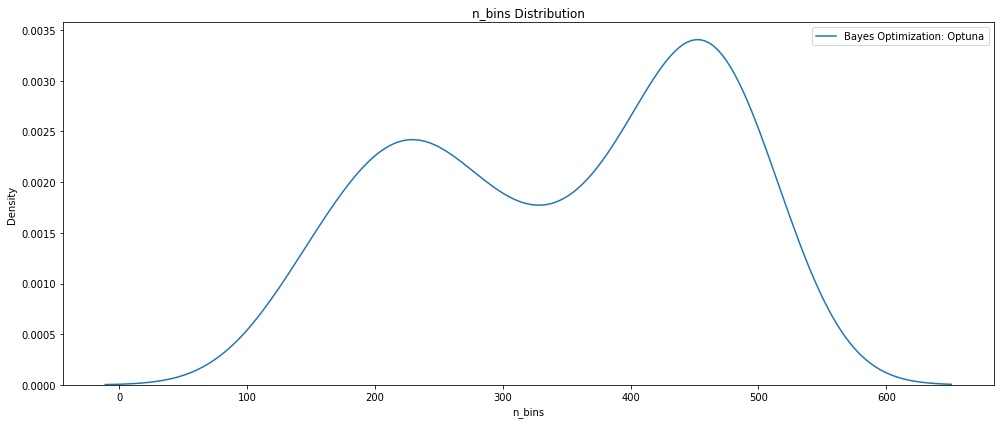

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'rmse', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning

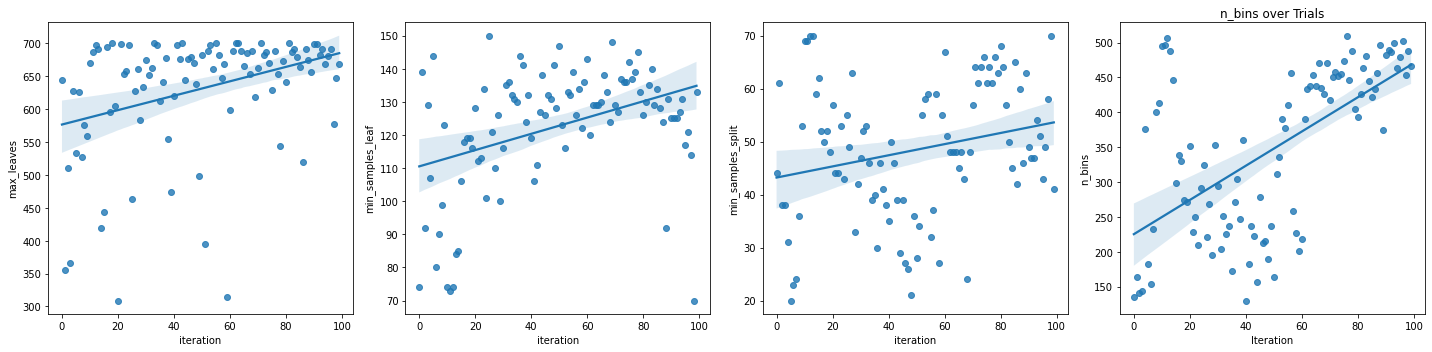

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize = (20, 5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['max_leaves', 'min_samples_leaf', 'min_samples_split',
                         'n_bins']): 

                        # Scatterplot
                         sns.regplot('iteration', hpo, data = trials_df, ax = axs[i]) 
axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo),  
                                    title = '{} over Trials'.format(hpo))

plt.tight_layout()
plt.show()


In [6]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/RF/Optuna/Model_Explanations/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/RF/Optuna/Model_Explanations


In [16]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_RF_Optuna_100_GPU_paramsHi.html')
fig.show()

In [17]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_RF_Optuna_100_GPU_paramsHi.html')
fig.show()

In [18]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params['random_state'] = seed_value
params

{'max_depth': 70,
 'max_leaves': 698,
 'min_samples_leaf': 133,
 'min_samples_split': 58,
 'n_bins': 390,
 'n_estimators': 904,
 'random_state': 42}

In [7]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/RF/Optuna/Model_PKL/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/RF/Optuna/Model_PKL


In [20]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed_value)

In [21]:
X_train = cudf.get_dummies(X_train, columns=cat_cols)
X_train = X_train.astype('float32')

In [22]:
X_test = cudf.get_dummies(X_test, columns=cat_cols)
X_test = X_test.astype('float32')

In [23]:
# Re-create the best model and train on the training data
best_model = RandomForestRegressor(n_streams=1, 
                                   **params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'RF_Optuna_trials100_GPU_paramsHi.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('RF_Optuna_trials100_GPU_paramsHi.pkl')
# print(model)
# =============================================================================

In [24]:
print('\nModel Metrics for RF HPO 100 GPU trials')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train.to_numpy(), y_train_pred.to_numpy()),
        mean_absolute_error(y_test.to_numpy(), y_test_pred.to_numpy())))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train.to_numpy(), y_train_pred.to_numpy()),
        mean_squared_error(y_test.to_numpy(), y_test_pred.to_numpy())))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train.to_numpy(), y_train_pred.to_numpy(), squared=False),
        mean_squared_error(y_test.to_numpy(), y_test_pred.to_numpy(), squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train.to_numpy(), y_train_pred.to_numpy()),
        r2_score(y_test.to_numpy(), y_test_pred.to_numpy())))


Model Metrics for RF HPO 100 GPU trials
MAE train: 2280.372, test: 2304.323
MSE train: 9398634.000, test: 9577225.000
RMSE train: 3065.719, test: 3094.709
R^2 train: 0.897, test: 0.895


In [25]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test.to_numpy(), y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 9577225.00000 MSE on the test set.
This was achieved using these conditions:
iteration                                    53
rmse                                3094.864502
datetime_start       2022-06-02 05:32:22.356034
datetime_complete    2022-06-02 05:34:45.985218
duration                 0 days 00:02:23.629184
max_depth                                    70
max_leaves                                  698
min_samples_leaf                            133
min_samples_split                            58
n_bins                                      390
n_estimators                                904
state                                  COMPLETE
Name: 0, dtype: object
